# Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import re, os, json
from pathlib import Path
from glob import glob
from pprint import pprint

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx as nx
import yaml
from IPython.display import Image

# Analyze the simple case

In [17]:
val_path = Path("").absolute() / "results/classic_grid_classic_grid/agg" / "val.csv"
df_classic = pd.read_csv(val_path)
best_acc = df_classic['accuracy'][np.argmax(df_classic['accuracy'])]
acc_std = df_classic['accuracy_std'][np.argmax(df_classic['accuracy'])]
print(f"Best test accuracy = {1e2 * best_acc:.1f} +/- {1e2 * acc_std:.1f}")

Best test accuracy = 85.6 +/- 3.3


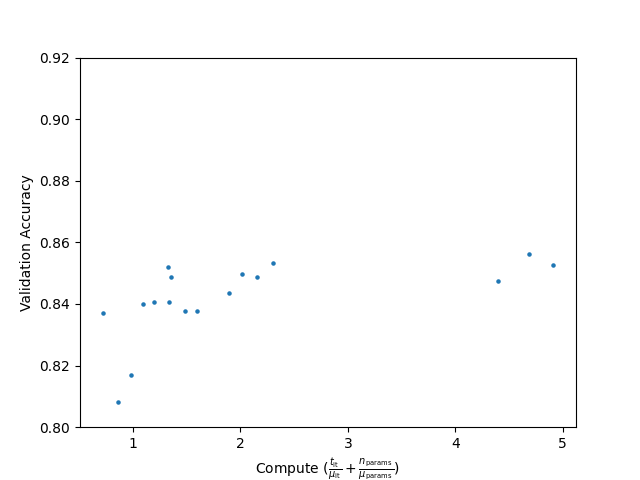

In [18]:
time_iter = df_classic["time_iter"].values / np.mean(df_classic["time_iter"])
params = df_classic["params"].values / np.mean(df_classic["params"])
compute_classic = time_iter + params
unit = "$\\frac{t_\\operatorname{it}}{\\mu_\\operatorname{it}} + \\frac{n_\\operatorname{params}}{\\mu_\\operatorname{params}}$"

plt.figure()
plt.scatter(compute_classic, df_classic["accuracy"], s=5)
plt.xlabel(f"Compute ({unit})")
plt.ylabel("Validation Accuracy")
plt.ylim([0.8, 0.92])
plt.show()


# Analyze the Neural Architecture Search (NAS) case

In [19]:
val_path = Path("").absolute() / "results/nas_grid_nas_grid/agg" / "val.csv"
df_nas = pd.read_csv(val_path)
best_acc = df_nas['accuracy'][np.argmax(df_nas['accuracy'])]
acc_std = df_nas['accuracy_std'][np.argmax(df_nas['accuracy'])]
print(f"Best test accuracy = {1e2 * best_acc:.1f} +/- {1e2 * acc_std:.1f}")

Best test accuracy = 88.3 +/- 1.0


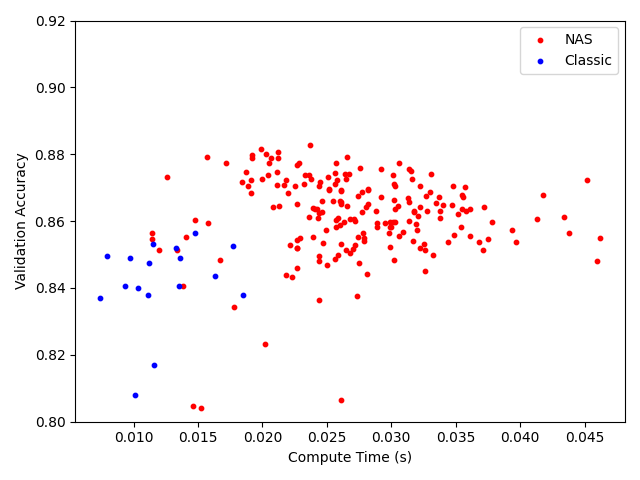

In [37]:
time_classic = df_classic["time_iter"].values
time_nas = df_nas["time_iter"].values

plt.figure()
plt.scatter(time_nas, df_nas["accuracy"], s=10, label="NAS", color="red")
plt.scatter(time_classic, df_classic["accuracy"], s=10, color="blue", label="Classic")
plt.xlabel(f"Compute Time (s)")
plt.ylabel("Validation Accuracy")
plt.ylim([0.8, 0.92])
plt.legend()
plt.tight_layout()
plt.savefig("figures/time_vs_acc.png", dpi=200, bbox_inches="tight", pad_inches=0.0)
plt.show()

# Draw a representative and a best cell

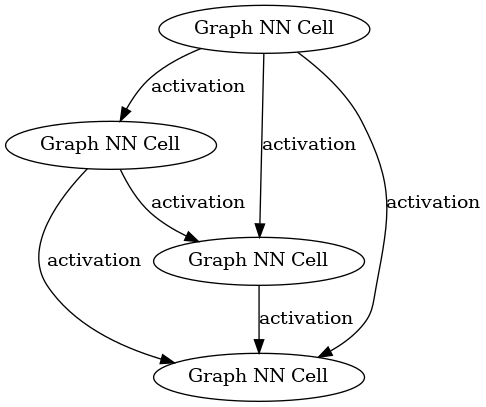

In [4]:
G = nx.DiGraph()
for i in range(4):
    G.add_node(f"node{i}", label="Graph NN Cell")
for i in range(3):
    for j in range(i + 1, 4):
        G.add_edge(f"node{i}", f"node{j}", label="activation")
AG = nx.nx_agraph.to_agraph(G)
graph_path = Path("").absolute() / "figures" / "nas_graph.png"
graph_path.parent.mkdir(exist_ok=True)
AG.draw(graph_path, prog="dot")
Image(graph_path)

In [30]:
def get_stats_and_config(config_path):
    try:
        stats_path = config_path / "agg" / "val" / "stats.json"
        stats = json.loads(stats_path.read_text().strip().split("\n")[-1])
        config = yaml.safe_load((config_path / "config.yaml").read_text())
        return stats, config, config_path
    except:
        return None

config_paths = list(Path("").absolute().glob("results/nas_grid_nas_grid/*"))
results = [get_stats_and_config(config_path) for config_path in config_paths]
results = [result for result in results if result is not None]
best_idx = np.argmax([stats["accuracy"] for (stats, _, _) in results])
best_config = results[best_idx][1]

In [31]:
G = nx.DiGraph()
for key in best_config["nas"]:
    m = re.fullmatch(r"node([0-9])", key)
    if m is not None:
        idx = int(m.group(1))
        label = f"{m.group(1)}: {best_config['nas'][key]}"
        if idx == 0:
            label += "\n(input)"
        elif idx == 3:
            label += "\n(output)"
        G.add_node(key, label=label)
for key in best_config["nas"]:
    m = re.fullmatch(r"node([0-9])([0-9])_act", key)
    if m is not None:
        n1, n2 = f"node{m.group(1)}", f"node{m.group(2)}"
        G.add_edge(n1, n2, label=best_config["nas"][key])

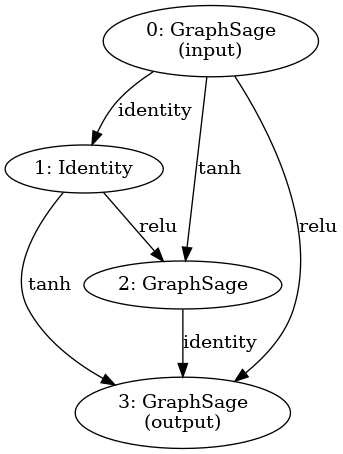

In [32]:
AG = nx.nx_agraph.to_agraph(G)
graph_path = Path("").absolute() / "figures" / "best_nas_graph.png"
graph_path.parent.mkdir(exist_ok=True)
AG.draw(graph_path, prog="dot")
Image(graph_path)

# Show differences in generalization

In [33]:
def read_accuracy(result_path):
    run_paths = [Path(p).absolute() for p in list(glob(str(result_path / "*")))]
    run_paths = [p for p in run_paths if re.fullmatch("agg", p.name)]
    stats_list = [
        [
            json.loads(line)
            for line in (run_path / "val" / "stats.json").read_text().strip().split("\n")
            if len(line) > 0
        ]
        for run_path in run_paths
    ]
    return stats_list

In [34]:
ridx = 192

In [35]:
best_result_path = results[best_idx][2]
random_result_path = results[ridx][2]
best_stats_list = read_accuracy(best_result_path)
random_stats_list = read_accuracy(random_result_path)
best_runs = [
    list(zip(*[(snap["epoch"], snap["accuracy"]) for snap in stats])) for stats in best_stats_list
]
random_runs = [
    list(zip(*[(snap["epoch"], snap["accuracy"]) for snap in stats])) for stats in random_stats_list
]

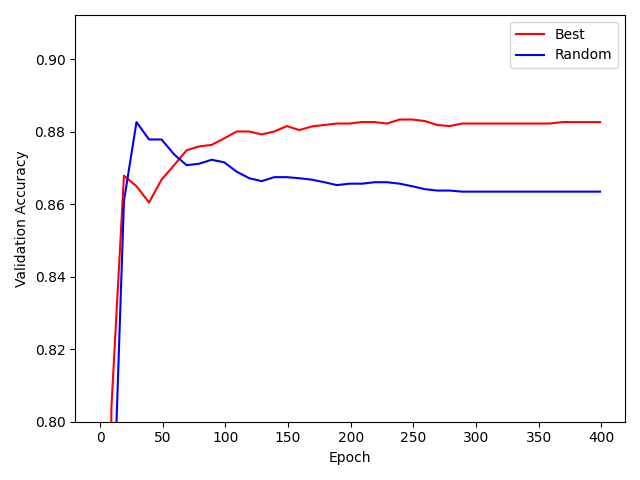

In [38]:
plt.figure()
for (epoch, accuracy) in best_runs:
    plt.plot(epoch, accuracy, color="red", label="Best")
for (epoch, accuracy) in random_runs:
    plt.plot(epoch, accuracy, color="blue", label="Random")
plt.xlabel("Epoch")
plt.ylim([0.8, plt.ylim()[1]])
plt.ylabel("Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("figures/best_vs_random.png", dpi=200, bbox_inches="tight", pad_inches=0)